In [1]:
import gym
import torch 
import collections
import os
import numpy as np
from utils import *
from exp_replay_memory import ReplayMemory
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [56]:
width=0.2
model_directory = "models/"
data_directory="data/"

# SARSA

In [57]:
def epsilon_greedy(q_func, observation, eps, env_actions):
    prob = np.random.random()

    if prob < eps:
        return random.choice(range(env_actions))
    elif isinstance(q_func, CNN) or isinstance(q_func, LinearMapNet):
        with torch.no_grad():
            return q_func(observation).max(1)[1].item()
    else:
        qvals = [q_func[observation + (action, )] for action in range(env_actions)]
        return np.argmax(qvals)
    
def greedy(qstates_dict, observation, env_actions):
    qvals = [qstates_dict[observation + (action, )] for action in range(env_actions)]
    return max(qvals)

In [58]:
def sarsa_lander(env, n_episodes, gamma, lr, min_eps,width, print_freq=500, render_freq=500):
    q_observations = collections.defaultdict(float)   # note that the first insertion of a key initializes its value to 0.0
    return_per_ep = [0.0]
    epsilon = 1.0
    num_actions = env.action_space.n
    
    for i in range(n_episodes):
        t = 0

        # Initial episode state: S
        state_continuous=env.reset()
        curr_state = discretize_state(state_continuous)

        if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
            curr_observation = (1,)
        else:
            curr_observation = discretize_state(state_continuous)
        # Choose A from S using policy π
        action = epsilon_greedy(q_observations, curr_observation, epsilon, num_actions)
        frame=0
        while True:
            
            # Create (S, A) pair
            qstate = curr_state + (action, )
            qobservation = curr_observation + (action, )

            # Take action A, earn immediate reward R and land into next state S'
            # S --> A --> R --> S'
            state_continuous, reward, done, _ = env.step(action)
            
            
            next_state = discretize_state(state_continuous)
            if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
                next_observation = (1,)
            else:
                next_observation = discretize_state(state_continuous)
            
            
            # Next State: S'
            # Choose A' from S' using policy π
            next_action = epsilon_greedy(q_observations, next_observation, epsilon, num_actions)

            # create (S', A') pair
            new_qstate = next_state + (next_action, )
            new_qobservation = next_observation + (next_action, )

            ###################################################################
            # Policy evaluation step
            if not done:
                q_observations[qobservation] += lr * (reward + gamma * q_observations[new_qobservation] - q_observations[qobservation]) # (S', A') non terminal state
            else:
                q_observations[qobservation] += lr * (reward - q_observations[qobservation])    # (S', A') terminal state
            ###################################################################

            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    print("\nEpisode finished after {} timesteps".format(t + 1))
                    print("Episode {}: Total Return = {}".format(i + 1, return_per_ep[-1]))
                    print("Total keys in q_observations dictionary = {}".format(len(q_observations)))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("Last 100 episodes mean reward: {}".format(mean_100ep_reward))

                epsilon = decay_epsilon(epsilon, min_eps)
                return_per_ep.append(0.0)

                break

            curr_state = next_state
            curr_observation = next_observation
            action = next_action
            t += 1

    return return_per_ep,q_observations

In [59]:
n_episodes=10000
lr=0.1
gamma=0.99
final_eps=0.01
environment = gym.make("LunarLander-v2")

In [60]:
print("\nTraining Sarsa lander with arguments num_episodes={}, step-size={}, gamma={}, final_epsilon={} ..."\
                            .format(n_episodes, lr, gamma, final_eps))
sarsa_total_rewards,q_observations  = sarsa_lander(environment, n_episodes, gamma, lr, final_eps,width)
print("Done!")




Training Sarsa lander with arguments num_episodes=10000, step-size=0.1, gamma=0.99, final_epsilon=0.01 ...
Last 100 episodes mean reward: -149.0
Last 100 episodes mean reward: -128.3
Last 100 episodes mean reward: -126.9
Last 100 episodes mean reward: -134.8

Episode finished after 153 timesteps
Episode 500: Total Return = -261.45076403541316
Total keys in q_observations dictionary = 8031
Last 100 episodes mean reward: -179.4
Last 100 episodes mean reward: -153.7
Last 100 episodes mean reward: -150.4
Last 100 episodes mean reward: -132.1
Last 100 episodes mean reward: -107.4

Episode finished after 317 timesteps
Episode 1000: Total Return = 264.8672660652145
Total keys in q_observations dictionary = 13274
Last 100 episodes mean reward: -109.6
Last 100 episodes mean reward: -65.0
Last 100 episodes mean reward: -86.3
Last 100 episodes mean reward: -40.8
Last 100 episodes mean reward: -55.9

Episode finished after 186 timesteps
Episode 1500: Total Return = -253.9242543260645
Total keys i

In [61]:
# #save result
a=np.array(sarsa_total_rewards)
np.save(data_directory+f'sarsa_total_rewards_width={width}.npy',a) 
with open(model_directory +f"sarsa_qtable_width={width}.pkl", "wb") as pkl_handle:
    pickle.dump(q_observations, pkl_handle)

# sarsa_total_rewards = np.load(f'sarsa_total_rewards_width={width}.npy').tolist()

# Q-learning

In [11]:
def qlearning_lander(env, n_episodes, gamma, lr, min_eps, print_freq=500, render_freq=500):
    q_states = collections.defaultdict(float)   # note that the first insertion of a key initializes its value to 0.0
    return_per_ep = [0.0]
    epsilon = 1.0
    num_actions = env.action_space.n
    
    for i in range(n_episodes):
        t = 0
        
        # Initial episode state: S
        state_continuous=env.reset()
        curr_state = discretize_state(state_continuous)
        
        if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
            curr_observation = (1,)
        else:
            curr_observation = curr_state
            
        
        
        while True:
            

            # choose action A from S using behaviour policy -> ε-greedy
            action = epsilon_greedy(q_states, curr_observation, epsilon, num_actions)

            # Create (S, A) pair
            qstate = curr_observation + (action, )

            # Take action A, earn immediate reward R and land into next state S'
            # S --> A --> R --> S'
            state_continuous, reward, done, _ = env.step(action)
            next_state = discretize_state(state_continuous)
            
            if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
                next_observation = (1,)
            else:
                next_observation = discretize_state(state_continuous)

            ###################################################################
            # Policy evaluation step
            if not done:
                q_states[qstate] += lr * (reward + gamma * greedy(q_states, next_observation, num_actions) - q_states[qstate]) # (S', A') non terminal state
            else:
                q_states[qstate] += lr * (reward - q_states[qstate])    # (S', A') terminal state
            ###################################################################

            return_per_ep[-1] += reward

            if done:
                
                if (i + 1) % print_freq == 0:
                    print("\nEpisode finished after {} timesteps".format(t + 1))
                    print("Episode {}: Total Return = {}".format(i + 1, return_per_ep[-1]))
                    print("Total keys in q_states dictionary = {}".format(len(q_states)))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("Last 100 episodes mean reward: {}".format(mean_100ep_reward))

                epsilon = decay_epsilon(epsilon, min_eps)
                return_per_ep.append(0.0)

                break

            curr_state = next_state
            curr_observation = next_observation
            
            t += 1

    return return_per_ep,q_states

In [12]:
n_episodes=10000
lr=0.1
gamma=0.99
final_eps=0.01
environment = gym.make("LunarLander-v2")

In [ ]:
print("\nTraining Sarsa lander with arguments num_episodes={}, step-size={}, gamma={}, final_epsilon={} ..."\
                            .format(n_episodes, lr, gamma, final_eps))
qlearning_total_rewards,q_observations  = qlearning_lander(environment, n_episodes, gamma, lr, final_eps)
print("Done!")



Training Sarsa lander with arguments num_episodes=10000, step-size=0.1, gamma=0.99, final_epsilon=0.01 ...
Last 100 episodes mean reward: -137.6
Last 100 episodes mean reward: -108.4
Last 100 episodes mean reward: -87.5
Last 100 episodes mean reward: -91.6

Episode finished after 346 timesteps
Episode 500: Total Return = -60.85789327075683
Total keys in q_states dictionary = 11800
Last 100 episodes mean reward: -94.9
Last 100 episodes mean reward: -90.7
Last 100 episodes mean reward: -91.4
Last 100 episodes mean reward: -100.8
Last 100 episodes mean reward: -88.5

Episode finished after 478 timesteps
Episode 1000: Total Return = -68.81096326258822
Total keys in q_states dictionary = 16980
Last 100 episodes mean reward: -82.7
Last 100 episodes mean reward: -102.5
Last 100 episodes mean reward: -63.7
Last 100 episodes mean reward: -58.8
Last 100 episodes mean reward: -89.2

Episode finished after 251 timesteps
Episode 1500: Total Return = -88.51376590078904
Total keys in q_states dictio

In [ ]:
# #save result
a=np.array(qlearning_total_rewards)
np.save(data_directory+f'qlearning_total_rewards_width={width}.npy',a) 
with open(model_directory +f"qlearning_qtable_width={width}.pkl", "wb") as pkl_handle:
    pickle.dump(q_observations, pkl_handle)



# DQN

In [3]:
def dqn_lander(env, n_episodes, gamma, lr, min_eps, width, \
                batch_size=32, memory_capacity=50000, \
                network='linear', learning_starts=500, \
                train_freq=1, target_network_update_freq=1000, \
                print_freq=500, render_freq=500, save_freq=1000):

    # set device to run on
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_function = torch.nn.MSELoss()

    # path to save checkpoints
    PATH = "./models"
    if not os.path.isdir(PATH):
        os.mkdir(PATH)

    num_actions = env.action_space.n
    
    input_shape = env.observation_space.shape[-1]+1
    
    qnet, qnet_optim = build_qnetwork(num_actions, lr, input_shape, network, device)
    qtarget_net, _ = build_qnetwork(num_actions, lr, input_shape, network, device)
    qtarget_net.load_state_dict(qnet.state_dict())
    qnet.train()
    qtarget_net.eval()
    replay_memory = ReplayMemory(memory_capacity)

    epsilon = 1.0 
    return_per_ep = [0.0] 
    saved_mean_reward = None
    t = 0

    for i in range(n_episodes):
        curr_state = lmn_input(env.reset())
        
        #add one dimension for blind or not, 1 for blind, 0 for not blind 
        curr_observation=torch.cat( (curr_state.squeeze(0),torch.tensor([0])) ).unsqueeze(0)
        curr_observation = torch.tensor([[0.,0.,0.,0.,0.,0.,0.,0.,1.]]) if curr_state[0][1]>=1-width/2 and curr_state[0][1]<=1+width/2 else curr_observation    

        
        
        while True:

            # choose action A using behaviour policy -> ε-greedy; use q-network
            action = epsilon_greedy(qnet, curr_observation.to(device), epsilon, num_actions)
            
            # take action A, earn immediate reward R and land into next state S'
            next_state, reward, done, _ = env.step(action)
            
            next_state = lmn_input(next_state)
            
            #add one dimension for blind or not, 1 for blind, 0 for not blind 
            next_observation =torch.cat( (next_state.squeeze(0),torch.tensor([0])) ).unsqueeze(0)
            next_observation =torch.tensor([[0.,0.,0.,0.,0.,0.,0.,0.,1.]]) if next_state[0][1]>=1-width/2 and  next_state[0][1]<=1+width/2 else next_observation

            # store transition (S, A, R, S', Done) in replay memory
            replay_memory.store(curr_observation, action, float(reward), next_observation, float(done))
            
            # if replay memory currently stores > 'learning_starts' transitions,
            # sample a random mini-batch and update q_network's parameters
            if t > learning_starts and t % train_freq == 0:
                curr_observations, actions, rewards, next_observations, dones = replay_memory.sample_minibatch(batch_size)
                #loss = 
                fit(qnet, \
                    qnet_optim, \
                    qtarget_net, \
                    loss_function, \
                    curr_observations, \
                    actions, \
                    rewards, \
                    next_observations, \
                    dones, \
                    gamma, \
                    num_actions, 
                    device)

            # periodically update q-target network's parameters
            if t > learning_starts and t % target_network_update_freq == 0:
                update_target_network(qnet, qtarget_net)

            t += 1
            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    print("\nEpisode: {}".format(i + 1))
                    print("Episode return : {}".format(return_per_ep[-1]))
                    print("Total time-steps: {}".format(t))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("\nLast 100 episodes mean reward: {}".format(mean_100ep_reward))

                if t > learning_starts and (i + 1) % save_freq == 0:
                    if saved_mean_reward is None or mean_100ep_reward > saved_mean_reward:
                        print("\nSaving model due to mean reward increase: {} -> {}".format(saved_mean_reward, mean_100ep_reward))
                        save_model(qnet, f"width={width}_episode={i+1}_rw={mean_100ep_reward}", PATH)
                        saved_mean_reward = mean_100ep_reward

                return_per_ep.append(0.0)
                epsilon = decay_epsilon(epsilon, min_eps)

                break
            current_state = next_state
            curr_observation = next_observation

    return return_per_ep

In [4]:
n_episodes= 10000
lr = 0.0005
gamma = 0.99
final_eps = 0.01

environment = gym.make("LunarLander-v2")

In [5]:
print("\nTraining DQN lander with arguments num_episodes={}, learning rate={}, gamma={}, final_epsilon={} ..."\
                            .format(n_episodes,lr, gamma, final_eps))
dqn_total_rewards = dqn_lander(environment, n_episodes, gamma, lr, final_eps,width)
print("Done!")


Training DQN lander with arguments num_episodes=10000, learning rate=0.0005, gamma=0.99, final_epsilon=0.01 ...

Last 100 episodes mean reward: -177.2

Last 100 episodes mean reward: -67.1

Last 100 episodes mean reward: -44.6

Last 100 episodes mean reward: 91.1

Episode: 500
Episode return : 227.5510501547813
Total time-steps: 241979

Last 100 episodes mean reward: 189.4

Last 100 episodes mean reward: 230.5

Last 100 episodes mean reward: 249.3

Last 100 episodes mean reward: 243.4

Last 100 episodes mean reward: 253.6

Episode: 1000
Episode return : 246.80755677316637
Total time-steps: 419607

Last 100 episodes mean reward: 252.3

Saving model due to mean reward increase: None -> 252.3

Last 100 episodes mean reward: 236.6

Last 100 episodes mean reward: 224.1

Last 100 episodes mean reward: 255.4

Last 100 episodes mean reward: 258.1

Episode: 1500
Episode return : 270.34666030056457
Total time-steps: 573761

Last 100 episodes mean reward: 246.6

Last 100 episodes mean reward: 25

In [6]:
# #save result
a=np.array(dqn_total_rewards)
np.save(data_directory+f'dqn_total_rewards_width={width}_lr={lr}_epochs={n_episodes}_dim=9.npy',a) 

# DQN with bonus

In [ ]:
def dqn_lander_reward(env, n_episodes, gamma, lr, min_eps, width, \
                batch_size=32, memory_capacity=50000, \
                network='linear', learning_starts=1000, \
                train_freq=1, target_network_update_freq=1000, \
                print_freq=500, render_freq=500, save_freq=1000):

    # set device to run on
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_function = torch.nn.MSELoss()

    # path to save checkpoints
    PATH = "./models"
    if not os.path.isdir(PATH):
        os.mkdir(PATH)

    num_actions = env.action_space.n   
    input_shape = env.observation_space.shape[-1]+1
    
    qnet, qnet_optim = build_qnetwork(num_actions, lr, input_shape, network, device)
    qtarget_net, _ = build_qnetwork(num_actions, lr, input_shape, network, device)
    qtarget_net.load_state_dict(qnet.state_dict())
    qnet.train()
    qtarget_net.eval()
    replay_memory = ReplayMemory(memory_capacity)
    

    epsilon = 1.0 
    return_per_ep = [0.0] 
    additional_rewards =[]
    saved_mean_reward = None
    t = 0

    for i in range(n_episodes):
        
        curr_state = lmn_input(env.reset())
        
        #add one dimension for blind or not, 1 for blind, 0 for not blind 
        curr_observation=torch.cat( (curr_state.squeeze(0),torch.tensor([0])) ).unsqueeze(0)
        curr_observation = torch.tensor([[0.,0.,0.,0.,0.,0.,0.,0.,1.]]) if curr_state[0][1]>=1-width/2 and curr_state[0][1]<=1+width/2 else curr_observation    
        
        # a decay factor to encourage exploration at early stage
        decay=np.exp(-0.001*i)
        past_actions=np.array([0,0,0,0])

        one_episode_reward=[]
        
        while True:

            # choose action A using behaviour policy -> ε-greedy; use q-network
            action = epsilon_greedy(qnet, curr_observation.to(device), epsilon, num_actions)
            

            # take action A, earn immediate reward R and land into next state S'
            next_state, reward, done, _ = env.step(action)

            past_actions[action]+=1
            c=np.array([0,0,0,0])
            c[action]=1
            
            
            add_rw=np.linalg.norm(c-past_actions/np.linalg.norm(past_actions)) *decay

            
            one_episode_reward.append(add_rw)
            reward+= add_rw

            
            next_state = lmn_input(next_state)
            
            #add one dimension for blind or not, 1 for blind, 0 for not blind 
            next_observation =torch.cat( (next_state.squeeze(0),torch.tensor([0])) ).unsqueeze(0)
            next_observation =torch.tensor([[0.,0.,0.,0.,0.,0.,0.,0.,1.]]) if next_state[0][1]>=1-width/2 and  next_state[0][1]<=1+width/2 else next_observation

            # store transition (S, A, R, S', Done) in replay memory
            replay_memory.store(curr_observation, action, float(reward), next_observation, float(done))
            
            # if replay memory currently stores > 'learning_starts' transitions,
            # sample a random mini-batch and update q_network's parameters
            if t > learning_starts and t % train_freq == 0:
                curr_observations, actions, rewards, next_observations, dones = replay_memory.sample_minibatch(batch_size)
                #loss = 
                fit(qnet, \
                    qnet_optim, \
                    qtarget_net, \
                    loss_function, \
                    curr_observations, \
                    actions, \
                    rewards, \
                    next_observations, \
                    dones, \
                    gamma, \
                    num_actions, 
                    device)

            # periodically update q-target network's parameters
            if t > learning_starts and t % target_network_update_freq == 0:
                update_target_network(qnet, qtarget_net)

            t += 1
            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    print("\nEpisode: {}".format(i + 1))
                    print("Episode return : {}".format(return_per_ep[-1]))
                    print("Total time-steps: {}".format(t))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("\nLast 100 episodes mean reward: {}".format(mean_100ep_reward))

                if t > learning_starts and (i + 1) % save_freq == 0:
                    if saved_mean_reward is None or mean_100ep_reward > saved_mean_reward:
                        print("\nSaving model due to mean reward increase: {} -> {}".format(saved_mean_reward, mean_100ep_reward))
                        save_model(qnet, f"width={width}_episode={i+1}_rw={mean_100ep_reward}_bonus" , PATH)
                        saved_mean_reward = mean_100ep_reward

                return_per_ep.append(0.0)
                epsilon = decay_epsilon(epsilon, min_eps)

                break
            current_state = next_state
            curr_observation = next_observation
        
        additional_rewards.append(np.sum(one_episode_reward))

    return return_per_ep,additional_rewards

In [ ]:
n_episodes= 10000
lr = 0.0005
gamma = 0.99
final_eps = 0.01

In [ ]:
print("\nTraining DQN lander with arguments num_episodes={}, learning rate={}, gamma={}, final_epsilon={} ..."\
                            .format(n_episodes,lr, gamma, final_eps))
dqn_total_rewards,additional_rewards = dqn_lander_reward(environment, n_episodes, gamma, lr, final_eps,width)
print("Done!")

In [ ]:
a=np.array(dqn_total_rewards)
b=np.array(additional_rewards)
np.save(data_directory+f'dqn_total_rewards_width={width}_lr={lr}_epochs={n_episodes}_dim=9_bonus.npy',a) 
np.save(data_directory+f'dqn_total_rewards_width={width}_lr={lr}_epochs={n_episodes}_dim=9_additional_reward.npy',b) 

# Test

In [64]:
n_episodes= 1000 #for test
env = gym.make("LunarLander-v2")

## Test Sarsa

In [9]:
def test_sarsa_lander(env, q_observations , n_episodes, width,epsilon=0, print_freq=500, render_freq=500):
    
    return_per_ep = [0.0]
    
    num_actions = env.action_space.n
    
    for i in range(n_episodes):
        t = 0

        # Initial episode state: S
        state_continuous=env.reset()
        curr_state = discretize_state(state_continuous)

        if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
            curr_observation = (1,)
        else:
            curr_observation = discretize_state(state_continuous)
        # Choose A from S using policy π
        # During test, we use greedy method instead of epsilon greedy       
        action = epsilon_greedy(q_observations, curr_observation, epsilon, num_actions)

        while True: 
            # Create (S, A) pair         
            qobservation = curr_observation + (action, )

            # Take action A, earn immediate reward R and land into next state S'
            # S --> A --> R --> S'
            state_continuous, reward, done, _ = env.step(action)
              
            next_state = discretize_state(state_continuous)
            if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
                next_observation = (1,)
            else:
                next_observation = discretize_state(state_continuous)
            
            
            # Next State: S'
            # Choose A' from S' using policy π
            next_action = epsilon_greedy(q_observations, curr_observation, epsilon, num_actions)

            # create (S', A') pair      
            new_qobservation = next_observation + (next_action, )

            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    print("\nEpisode finished after {} timesteps".format(t + 1))
                    print("Episode {}: Total Return = {}".format(i + 1, return_per_ep[-1]))
                    print("Total keys in q_observations dictionary = {}".format(len(q_observations)))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("Last 100 episodes mean reward: {}".format(mean_100ep_reward))

                
                return_per_ep.append(0.0)

                break

            curr_state = next_state
            curr_observation = next_observation
            action = next_action
            t += 1

    return return_per_ep

In [76]:
for width in [0.2,0.4]:
    q_observations = pickle.load(open( model_directory+ f"sarsa_qtable_width={width}.pkl", 'rb'))
    test_sarsa_total_rewards = test_sarsa_lander(env, q_observations , n_episodes, width)
    np.save(data_directory+f'test_sarsa_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_sarsa_total_rewards)) 

Last 100 episodes mean reward: 121.6
Last 100 episodes mean reward: 102.0
Last 100 episodes mean reward: 112.8
Last 100 episodes mean reward: 115.0

Episode finished after 321 timesteps
Episode 500: Total Return = -35.96376521883853
Total keys in q_observations dictionary = 50837
Last 100 episodes mean reward: 110.0
Last 100 episodes mean reward: 106.1
Last 100 episodes mean reward: 94.8
Last 100 episodes mean reward: 113.2
Last 100 episodes mean reward: 115.2

Episode finished after 343 timesteps
Episode 1000: Total Return = 196.44481265888004
Total keys in q_observations dictionary = 51713
Last 100 episodes mean reward: 117.9
Last 100 episodes mean reward: 0.8
Last 100 episodes mean reward: -11.7
Last 100 episodes mean reward: -18.8
Last 100 episodes mean reward: -20.5

Episode finished after 117 timesteps
Episode 500: Total Return = -63.77192360106311
Total keys in q_observations dictionary = 42272
Last 100 episodes mean reward: -18.3
Last 100 episodes mean reward: -14.8
Last 100 ep

In [72]:
for width in [0,0.2]:
    q_observations = pickle.load(open( model_directory+ f"sarsa_qtable_width={width}.pkl", 'rb'))
    test_sarsa_total_rewards = test_sarsa_lander(env, q_observations , n_episodes, width)
    np.save(data_directory+f'test_sarsa_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_sarsa_total_rewards))

Last 100 episodes mean reward: 154.3
Last 100 episodes mean reward: 172.0
Last 100 episodes mean reward: 156.5
Last 100 episodes mean reward: 155.2

Episode finished after 693 timesteps
Episode 500: Total Return = 142.68092463996706
Total keys in q_observations dictionary = 44536
Last 100 episodes mean reward: 148.2
Last 100 episodes mean reward: 154.0
Last 100 episodes mean reward: 146.6
Last 100 episodes mean reward: 145.8
Last 100 episodes mean reward: 161.6

Episode finished after 628 timesteps
Episode 1000: Total Return = -71.42961336773264
Total keys in q_observations dictionary = 44830
Last 100 episodes mean reward: 153.0
Last 100 episodes mean reward: 99.6
Last 100 episodes mean reward: 90.3
Last 100 episodes mean reward: 112.7
Last 100 episodes mean reward: 89.1

Episode finished after 364 timesteps
Episode 500: Total Return = 261.30498391476146
Total keys in q_observations dictionary = 51504
Last 100 episodes mean reward: 104.2
Last 100 episodes mean reward: 116.8
Last 100 ep

## Test Q-learning

In [20]:
def test_qlearning_lander(env, q_states ,n_episodes,width, print_freq=500, render_freq=500):
    
    return_per_ep = [0.0]
    epsilon = 0
    num_actions = env.action_space.n
    
    for i in range(n_episodes):
        t = 0
        
        # Initial episode state: S
        state_continuous=env.reset()
        curr_state = discretize_state(state_continuous)
        
        if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
            curr_observation = (1,)
        else:
            curr_observation = curr_state
            
        
        
        while True:
            

            # choose action A from S using behaviour policy -> ε-greedy
            action = epsilon_greedy(q_states, curr_observation, epsilon, num_actions)

            # Create (S, A) pair
            qstate = curr_observation + (action, )

            # Take action A, earn immediate reward R and land into next state S'
            # S --> A --> R --> S'
            state_continuous, reward, done, _ = env.step(action)
            next_state = discretize_state(state_continuous)
            
            if state_continuous[1]>=1-width/2  and state_continuous[1]<=1+width/2 :
                next_observation = (1,)
            else:
                next_observation = discretize_state(state_continuous)

            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    print("\nEpisode finished after {} timesteps".format(t + 1))
                    print("Episode {}: Total Return = {}".format(i + 1, return_per_ep[-1]))
                    print("Total keys in q_states dictionary = {}".format(len(q_states)))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("Last 100 episodes mean reward: {}".format(mean_100ep_reward))

               
                return_per_ep.append(0.0)

                break

            curr_state = next_state
            curr_observation = next_observation
            
            t += 1

    return return_per_ep

In [15]:
for width in [0.2,0.4]:
    q_observations = pickle.load(open( model_directory+ f"qlearning_qtable_width={width}.pkl", 'rb'))
    test_qlearning_total_rewards = test_qlearning_lander(env, q_observations , n_episodes, width)
    np.save(data_directory+f'test_qlearning_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_qlearning_total_rewards)) 

In [62]:
for width in [0.2]:
    q_observations = pickle.load(open( model_directory+ f"qlearning_qtable_width={width}.pkl", 'rb'))
    test_qlearning_total_rewards = test_qlearning_lander(env, q_observations , n_episodes, width)
    np.save(data_directory+f'test_qlearning_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_qlearning_total_rewards)) 

KeyboardInterrupt: 

## Test DQN(bonus)

In [23]:
def test_dqn_lander(env, n_episodes, width, \
                qtarget_net, epsilon = 0, print_freq=100):

    # set device to run on
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    loss_function = torch.nn.MSELoss()

    

    num_actions = env.action_space.n
    
    input_shape = env.observation_space.shape[-1]+1
    
    # our loaded model 
    qtarget_net.eval()
    
    
    return_per_ep = [0.0] 
    
    t = 0

    for i in range(n_episodes):
        curr_state = lmn_input(env.reset())
        
        #add one dimension for blind or not, 1 for blind, 0 for not blind 
        curr_observation=torch.cat( (curr_state.squeeze(0),torch.tensor([0])) ).unsqueeze(0)
        curr_observation = torch.tensor([[0.,0.,0.,0.,0.,0.,0.,0.,1.]]) if curr_state[0][1]>=1-width/2 and curr_state[0][1]<=1+width/2 else curr_observation    

        
        
        while True:

            # choose action A using behaviour policy -> ε-greedy; use q-network
            action = epsilon_greedy(qtarget_net, curr_observation.to(device), epsilon, num_actions)
            
            # take action A, earn immediate reward R and land into next state S'
            next_state, reward, done, _ = env.step(action)
            
            next_state = lmn_input(next_state)
            
            #add one dimension for blind or not, 1 for blind, 0 for not blind 
            next_observation =torch.cat( (next_state.squeeze(0),torch.tensor([0])) ).unsqueeze(0)
            next_observation =torch.tensor([[0.,0.,0.,0.,0.,0.,0.,0.,1.]]) if next_state[0][1]>=1-width/2 and  next_state[0][1]<=1+width/2 else next_observation

            # if replay memory currently stores > 'learning_starts' transitions,
            # sample a random mini-batch and update q_network's parameters
            
            t += 1
            return_per_ep[-1] += reward

            if done:
                if (i + 1) % print_freq == 0:
                    print("\nEpisode: {}".format(i + 1))
                    print("Episode return : {}".format(return_per_ep[-1]))
                    print("Total time-steps: {}".format(t))

                if (i + 1) % 100 == 0:
                    mean_100ep_reward = round(np.mean(return_per_ep[-101:-1]), 1)
                    print("\nLast 100 episodes mean reward: {}".format(mean_100ep_reward))

                
                return_per_ep.append(0.0)
                

                break
            current_state = next_state
            curr_observation = next_observation

    return return_per_ep

### Test DQN

In [37]:
width =0
model = LinearMapNet(env.observation_space.shape[-1]+1,env.action_space.n)
model.load_state_dict(torch.load(model_directory+"qnetwork_width=0_episode=10000_rw=280.1.pt"))
test_rewards = test_dqn_lander(env, n_episodes, width, model )
np.save(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_rewards)) 


Episode: 100
Episode return : 287.3924866956862
Total time-steps: 23698

Last 100 episodes mean reward: 280.1

Episode: 200
Episode return : 250.30278662848053
Total time-steps: 46071

Last 100 episodes mean reward: 277.2

Episode: 300
Episode return : 290.2418260269203
Total time-steps: 69351

Last 100 episodes mean reward: 276.6

Episode: 400
Episode return : 289.031080081678
Total time-steps: 91217

Last 100 episodes mean reward: 278.4

Episode: 500
Episode return : 309.833985307052
Total time-steps: 116041

Last 100 episodes mean reward: 277.5

Episode: 600
Episode return : 240.35120089181896
Total time-steps: 141680

Last 100 episodes mean reward: 277.7

Episode: 700
Episode return : 307.5129521384947
Total time-steps: 163987

Last 100 episodes mean reward: 276.9

Episode: 800
Episode return : 297.0638682211993
Total time-steps: 188133

Last 100 episodes mean reward: 276.4

Episode: 900
Episode return : 263.0413871747912
Total time-steps: 211928

Last 100 episodes mean reward: 27

In [97]:
width =0.2
model = LinearMapNet(env.observation_space.shape[-1]+1,env.action_space.n)
model.load_state_dict(torch.load(model_directory+"qnetwork_width=0.2_episode=4000_rw=249.0.pt"))
test_rewards = test_dqn_lander(env, n_episodes, width, model )
np.save(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_rewards)) 


Episode: 100
Episode return : 289.55812803542466
Total time-steps: 28759

Last 100 episodes mean reward: 256.7

Episode: 200
Episode return : 266.61538368271204
Total time-steps: 57545

Last 100 episodes mean reward: 249.7

Episode: 300
Episode return : 263.77329407228154
Total time-steps: 85787

Last 100 episodes mean reward: 262.0

Episode: 400
Episode return : 281.4355348241671
Total time-steps: 113714

Last 100 episodes mean reward: 254.7

Episode: 500
Episode return : 266.88413882536554
Total time-steps: 142068

Last 100 episodes mean reward: 253.4

Episode: 600
Episode return : 291.708240567457
Total time-steps: 169644

Last 100 episodes mean reward: 263.3

Episode: 700
Episode return : 275.50486704336345
Total time-steps: 199015

Last 100 episodes mean reward: 251.8

Episode: 800
Episode return : 230.342332305558
Total time-steps: 228117

Last 100 episodes mean reward: 254.3

Episode: 900
Episode return : 160.619350109166
Total time-steps: 257006

Last 100 episodes mean reward:

In [98]:
width =0.4
model = LinearMapNet(env.observation_space.shape[-1]+1,env.action_space.n)
model.load_state_dict(torch.load(model_directory+"qnetwork_width=0.4_episode=5000_rw=171.3.pt"))
test_rewards = test_dqn_lander(env, n_episodes, width, model )
np.save(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}.npy',np.array(test_rewards)) 


Episode: 100
Episode return : 287.24932423425753
Total time-steps: 35250

Last 100 episodes mean reward: 186.1

Episode: 200
Episode return : 269.34877902754084
Total time-steps: 64206

Last 100 episodes mean reward: 176.2

Episode: 300
Episode return : 270.4674676682286
Total time-steps: 95033

Last 100 episodes mean reward: 188.5

Episode: 400
Episode return : 266.64482673501414
Total time-steps: 122436

Last 100 episodes mean reward: 153.3

Episode: 500
Episode return : 244.99606665745407
Total time-steps: 151398

Last 100 episodes mean reward: 185.0

Episode: 600
Episode return : 232.2510931919105
Total time-steps: 183235

Last 100 episodes mean reward: 182.1

Episode: 700
Episode return : 249.20602900434577
Total time-steps: 209717

Last 100 episodes mean reward: 175.1

Episode: 800
Episode return : 250.15596877107623
Total time-steps: 241384

Last 100 episodes mean reward: 202.7

Episode: 900
Episode return : 268.2622367355326
Total time-steps: 271395

Last 100 episodes mean rew

### Test DQN BONUS

In [30]:
width =0
model = LinearMapNet(env.observation_space.shape[-1]+1,env.action_space.n)
model.load_state_dict(torch.load(model_directory+"qnetwork_width=0_episode=1000_rw=357.7_bonus.pt"))
test_rewards = test_dqn_lander(env, n_episodes, width, model )
np.save(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}_bonus.npy',np.array(test_rewards)) 


Episode: 100
Episode return : 108.23118705790736
Total time-steps: 38857

Last 100 episodes mean reward: 225.6

Episode: 200
Episode return : 204.66032006722466
Total time-steps: 79542

Last 100 episodes mean reward: 216.1

Episode: 300
Episode return : 226.61776446016472
Total time-steps: 124462

Last 100 episodes mean reward: 215.0

Episode: 400
Episode return : 218.36481837331308
Total time-steps: 163345

Last 100 episodes mean reward: 220.2

Episode: 500
Episode return : 233.7118408525533
Total time-steps: 205332

Last 100 episodes mean reward: 223.4

Episode: 600
Episode return : -20.92538232599088
Total time-steps: 242536

Last 100 episodes mean reward: 216.1

Episode: 700
Episode return : 212.00683840405472
Total time-steps: 280000

Last 100 episodes mean reward: 226.4

Episode: 800
Episode return : 229.6606950956184
Total time-steps: 322171

Last 100 episodes mean reward: 224.1

Episode: 900
Episode return : 251.09904782942436
Total time-steps: 360224

Last 100 episodes mean r

In [100]:
width =0.2
model = LinearMapNet(env.observation_space.shape[-1]+1,env.action_space.n)
model.load_state_dict(torch.load(model_directory+"qnetwork_width=0.2_episode=1000_rw=341.3_bonus.pt"))
test_rewards = test_dqn_lander(env, n_episodes, width, model )
np.save(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}_bonus.npy',np.array(test_rewards)) 


Episode: 100
Episode return : 247.2860472548962
Total time-steps: 38089

Last 100 episodes mean reward: 216.0

Episode: 200
Episode return : 26.961879724348023
Total time-steps: 77983

Last 100 episodes mean reward: 217.3

Episode: 300
Episode return : 260.3926082254161
Total time-steps: 116622

Last 100 episodes mean reward: 216.8

Episode: 400
Episode return : 216.48535865939408
Total time-steps: 154619

Last 100 episodes mean reward: 198.3

Episode: 500
Episode return : 230.16639613112932
Total time-steps: 194426

Last 100 episodes mean reward: 217.2

Episode: 600
Episode return : 211.83372359317525
Total time-steps: 233641

Last 100 episodes mean reward: 217.3

Episode: 700
Episode return : 273.31790343174134
Total time-steps: 272109

Last 100 episodes mean reward: 236.0

Episode: 800
Episode return : 121.50258029566533
Total time-steps: 312527

Last 100 episodes mean reward: 204.0

Episode: 900
Episode return : 136.11641977094465
Total time-steps: 350278

Last 100 episodes mean r

In [101]:
width =0.4
model = LinearMapNet(env.observation_space.shape[-1]+1,env.action_space.n)
model.load_state_dict(torch.load(model_directory+"qnetwork_width=0.4_episode=1000_rw=238.6_bonus.pt"))
test_rewards = test_dqn_lander(env, n_episodes, width, model )
np.save(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}_bonus.npy',np.array(test_rewards)) 


Episode: 100
Episode return : 172.7275635613902
Total time-steps: 43148

Last 100 episodes mean reward: 163.4

Episode: 200
Episode return : 252.64825426482628
Total time-steps: 79786

Last 100 episodes mean reward: 148.0

Episode: 300
Episode return : 243.95046057073557
Total time-steps: 119139

Last 100 episodes mean reward: 170.3

Episode: 400
Episode return : 221.00737571733362
Total time-steps: 155586

Last 100 episodes mean reward: 164.7

Episode: 500
Episode return : 135.5393485578989
Total time-steps: 194712

Last 100 episodes mean reward: 161.8

Episode: 600
Episode return : 212.651392557173
Total time-steps: 233045

Last 100 episodes mean reward: 173.0

Episode: 700
Episode return : 211.2880970473869
Total time-steps: 268916

Last 100 episodes mean reward: 173.2

Episode: 800
Episode return : -45.58988771324086
Total time-steps: 309021

Last 100 episodes mean reward: 156.9

Episode: 900
Episode return : 128.06797856647336
Total time-steps: 347216

Last 100 episodes mean rewa

# Plot

## Plot use test data

In [73]:
# laod test data
width = 0.2
test_qlearning_2= np.load(data_directory+ f'test_qlearning_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_sarsa_2= np.load(data_directory+f'test_sarsa_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_dqn_2= np.load(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_dqn_bonus_2= np.load(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}_bonus.npy').tolist()

width =0.4
test_qlearning_4= np.load(data_directory+f'test_qlearning_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_sarsa_4= np.load(data_directory+f'test_sarsa_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_dqn_4= np.load(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_dqn_bonus_4= np.load(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}_bonus.npy').tolist()

width=0
test_qlearning_0= np.load(data_directory+f'test_qlearning_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_sarsa_0= np.load(data_directory+f'test_sarsa_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_dqn_0= np.load(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}.npy').tolist()
test_dqn_bonus_0= np.load(data_directory+f'test_dqn_total_rewards_width={width}_epochs={n_episodes}_bonus.npy').tolist()

In [74]:
def cal_mean_std(data):
    mean=[]
    std=[]
    for datum in data:
        mean.append(np.mean(datum))
        std.append(np.std(datum))
    return mean, std

In [75]:
def plot_mean_std(agents,data,width):       
    mean, std = cal_mean_std(data)
    
    sns.set_theme(style="whitegrid")
    
    for agent,m, s in zip(agents,mean,std):
        print(f"{agent} average reward = {m}, std={s} when blind area width = {width}")
    plt.figure(figsize=(12,6))
    plt.errorbar(agents, mean, std, linestyle='None', marker='+')
    plt.xlabel("Different Agents")
    plt.ylabel("Reward")
    plt.title(f"Mean reward and standard deviation, when blind area width is {width}")

    plt.show()

SARSA average reward = 154.33906106833226, std=91.38559084021833 when blind area width = 0
Q Learning average reward = 158.9604940326365, std=95.39014175802983 when blind area width = 0
DQN average reward = 277.2566383225383, std=26.67043854888817 when blind area width = 0
DQN_bonus average reward = 221.22702666050458, std=71.48742574793947 when blind area width = 0


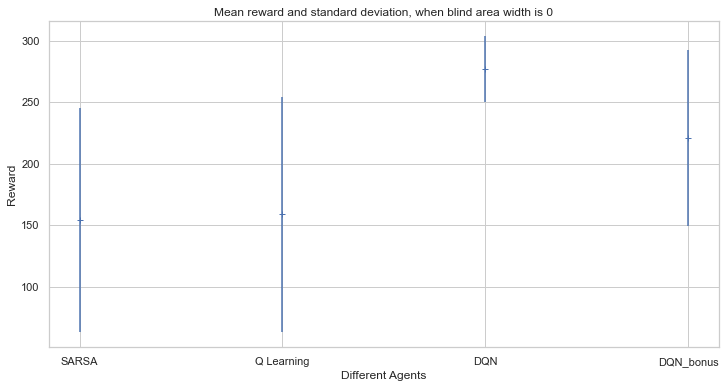

In [76]:
width=0
agents = ['SARSA','Q Learning','DQN','DQN_bonus']
data=[test_sarsa_0,test_qlearning_0,test_dqn_0,test_dqn_bonus_0]
plot_mean_std(agents,data,width)

SARSA average reward = 106.94438888575998, std=134.2649419331813 when blind area width = 0.2
Q Learning average reward = 101.54602405206336, std=134.80134779502848 when blind area width = 0.2
DQN average reward = 256.1684043283583, std=63.47869785943094 when blind area width = 0.2
DQN_bonus average reward = 213.33449345323726, std=82.56562938378877 when blind area width = 0.2


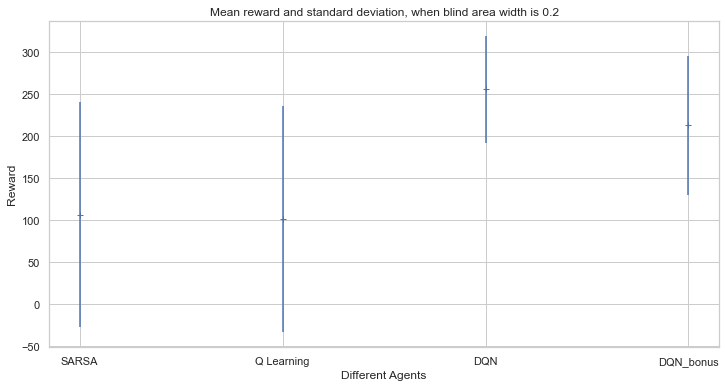

In [77]:
width=0.2
agents = ['SARSA','Q Learning','DQN','DQN_bonus']
data=[test_sarsa_2,test_qlearning_2,test_dqn_2,test_dqn_bonus_2]
plot_mean_std(agents,data,width)

SARSA average reward = -15.007019778414989, std=80.14219445065946 when blind area width = 0.4
Q Learning average reward = 41.939969652149806, std=120.52846378957842 when blind area width = 0.4
DQN average reward = 175.40383718568756, std=133.6693746959066 when blind area width = 0.4
DQN_bonus average reward = 161.35971176642875, std=136.42014248262603 when blind area width = 0.4


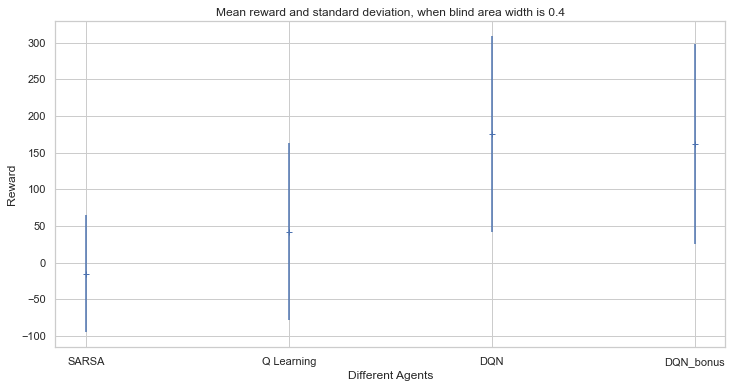

In [141]:
width=0.4
agents = ['SARSA','Q Learning','DQN','DQN_bonus']
data=[test_sarsa_4,test_qlearning_4,test_dqn_4,test_dqn_bonus_4]
plot_mean_std(agents,data,width)

In [35]:
def plot_cumulative_reward(agents,data,title):
    cumulative_sum =[]
    for datum in data:
        cumulative_sum.append(np.cumsum(datum)) 
        
        sns.set_theme(style="darkgrid")
    
    x=np.arange(len(cumulative_sum[0]))
    plt.figure(figsize=(12,8))
    for agent, cum_sum in zip(agents,cumulative_sum ):    
        sns.lineplot(x=x,y=cum_sum,label=agent )
        plt.fill_between(x,0,cum_sum,alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel("Cumulative Rewards")
    plt.title(title)
    plt.legend()

    plt.show()
    

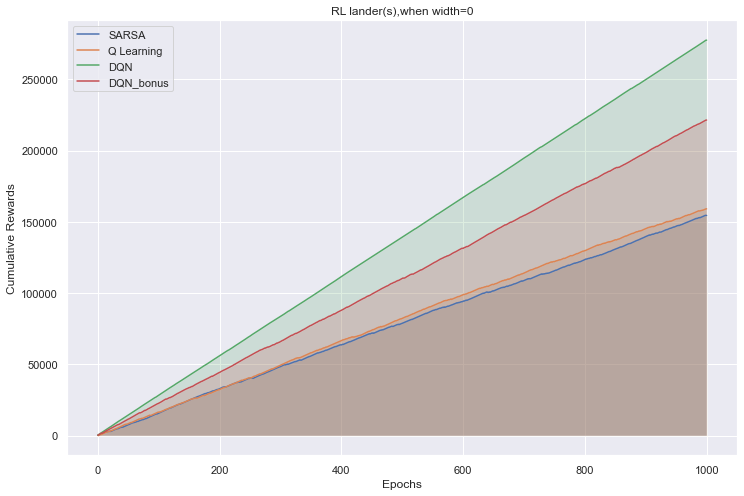

In [78]:
width=0
title=f"RL lander(s),when width={width}"
agents = ['SARSA','Q Learning','DQN','DQN_bonus']
data=[test_sarsa_0,test_qlearning_0,test_dqn_0,test_dqn_bonus_0]
plot_cumulative_reward(agents,data,title)

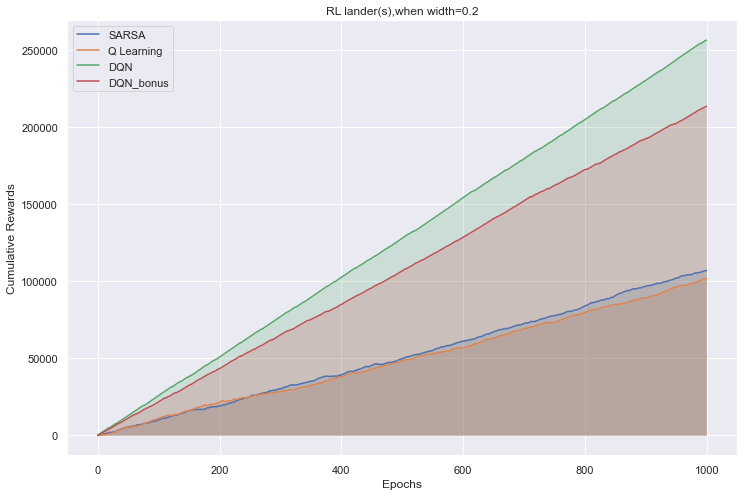

In [79]:
width=0.2
title=f"RL lander(s),when width={width}"
agents = ['SARSA','Q Learning','DQN','DQN_bonus']
data=[test_sarsa_2,test_qlearning_2,test_dqn_2,test_dqn_bonus_2]
plot_cumulative_reward(agents,data,title)

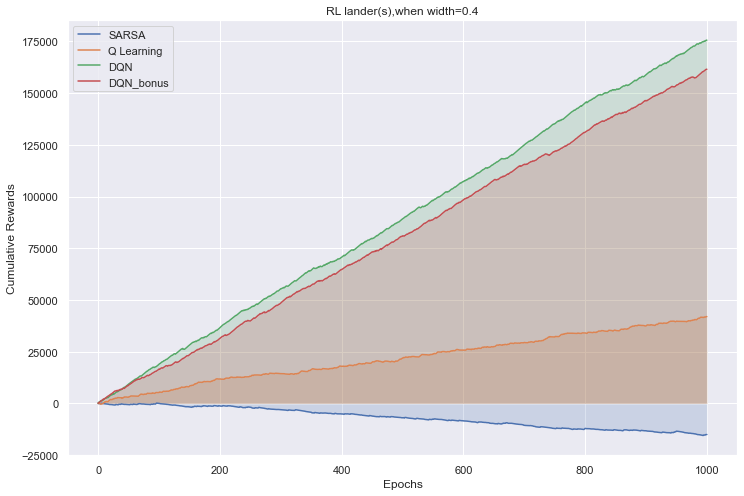

In [80]:
width=0.4
title=f"RL lander(s),when width={width}"
agents = ['SARSA','Q Learning','DQN','DQN_bonus']
data=[test_sarsa_4,test_qlearning_4,test_dqn_4,test_dqn_bonus_4]
plot_cumulative_reward(agents,data,title)

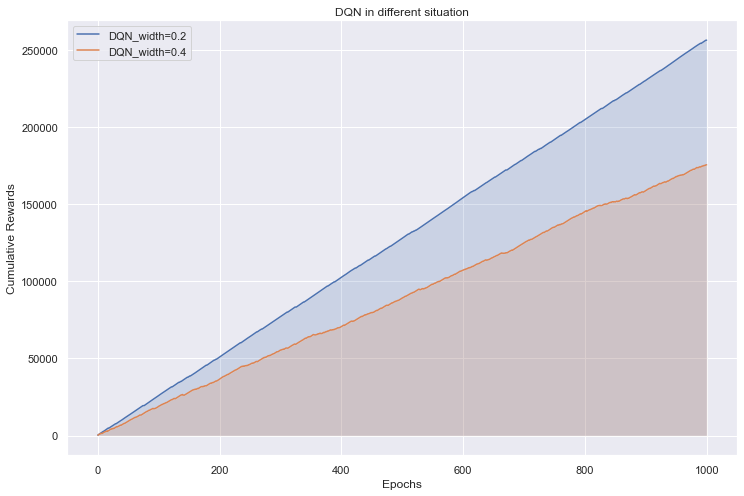

In [145]:
title=f"DQN in different situation"
agents = ['DQN_width=0.2','DQN_width=0.4']
data=[test_dqn_2,test_dqn_4]
plot_cumulative_reward(agents,data,title)

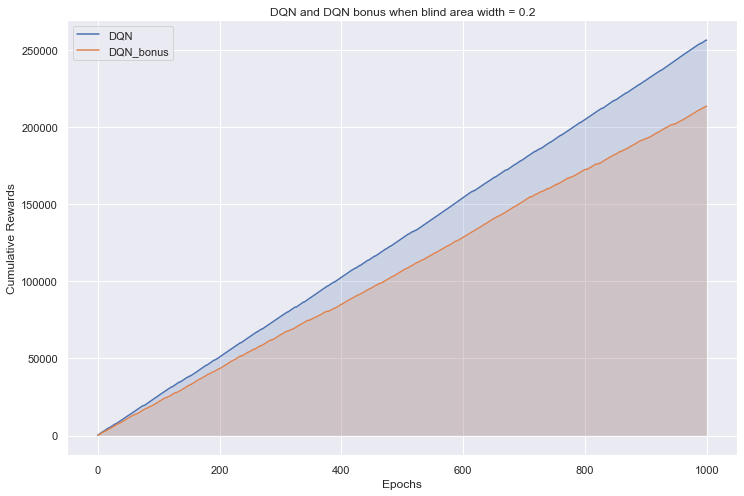

In [146]:
title=f"DQN and DQN bonus when blind area width = 0.2"
agents = ['DQN','DQN_bonus']
data=[test_dqn_2,test_dqn_bonus_2]
plot_cumulative_reward(agents,data,title)

##  Plot use training data

In [81]:
# load training data
dqn_total_rewards_2 = np.load(data_directory+f'dqn_total_rewards_width=0.2_lr=0.0005_epochs=10000_dim=9.npy').tolist()
dqn_total_rewards_4 = np.load(data_directory+f'dqn_total_rewards_width=0.4_lr=0.0005_epochs=10000_dim=9.npy').tolist()


dqn_bonus_total_rewards_2=np.load(data_directory+f'dqn_total_rewards_width=0.2_lr=0.0005_epochs=10000_dim=9_bonus.npy')
dqn_bonus_add_rw_2=np.load(data_directory+'dqn_total_rewards_width=0.2_lr=0.0005_epochs=10000_dim=9_additional_reward.npy')
dqn_bonus_total_rewards_4=np.load(data_directory+'dqn_total_rewards_width=0.4_lr=0.0005_epochs=10000_dim=9_bonus.npy')
dqn_bonus_add_rw_4=np.load(data_directory+'dqn_total_rewards_width=0.4_lr=0.0005_epochs=10000_dim=9_additional_reward.npy')

dqn_bonus_total_rewards_2= (dqn_bonus_total_rewards_2[:-1]-dqn_bonus_add_rw_2).tolist()
dqn_bonus_total_rewards_4= (dqn_bonus_total_rewards_4[:-1]-dqn_bonus_add_rw_4).tolist()

sarsa_total_rewards_2 = np.load(data_directory+f'sarsa_total_rewards_width=0.2.npy').tolist()
sarsa_total_rewards_4 = np.load(data_directory+f'sarsa_total_rewards_width=0.4.npy').tolist()

qlearning_total_rewards_2 = np.load(data_directory+f'qlearning_total_rewards_width=0.2.npy').tolist()
qlearning_total_rewards_4 = np.load(data_directory+f'qlearning_total_rewards_width=0.4.npy').tolist()

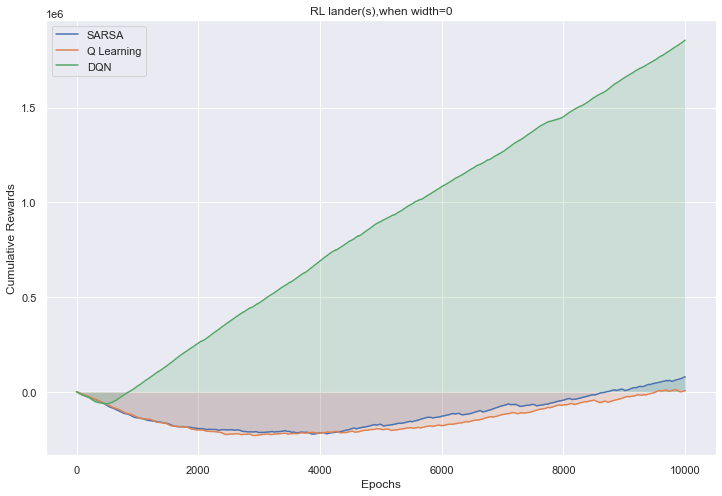

In [86]:
width=0
title=f"RL lander(s),when width={width}"
agents = ['SARSA','Q Learning','DQN']
data=[sarsa_total_rewards_2,qlearning_total_rewards_2,dqn_total_rewards_2]
plot_cumulative_reward(agents,data,title)

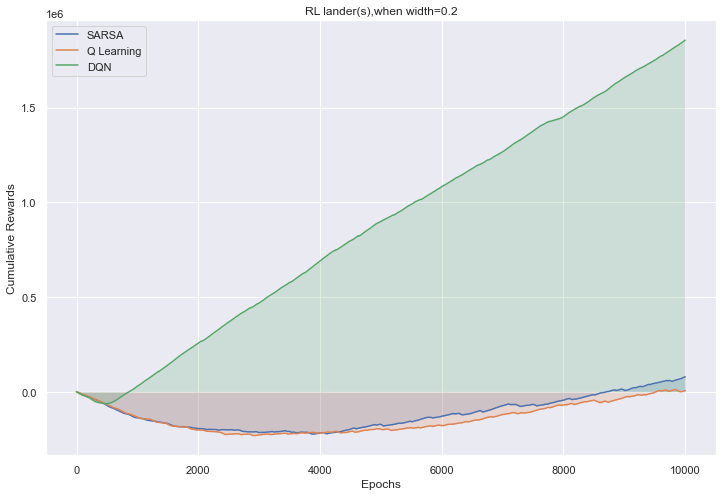

In [82]:
width=0.2
title=f"RL lander(s),when width={width}"
agents = ['SARSA','Q Learning','DQN']
data=[sarsa_total_rewards_2,qlearning_total_rewards_2,dqn_total_rewards_2]
plot_cumulative_reward(agents,data,title)

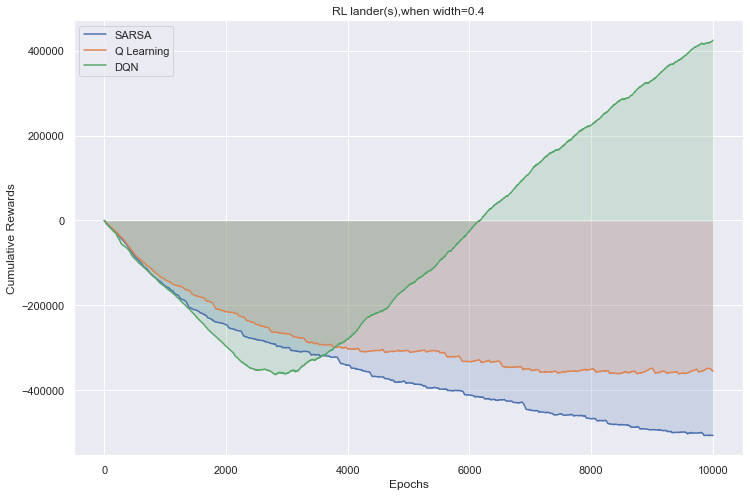

In [83]:
width=0.4
title=f"RL lander(s),when width={width}"
agents = ['SARSA','Q Learning','DQN']
data=[sarsa_total_rewards_4,qlearning_total_rewards_4,dqn_total_rewards_4]
plot_cumulative_reward(agents,data,title)

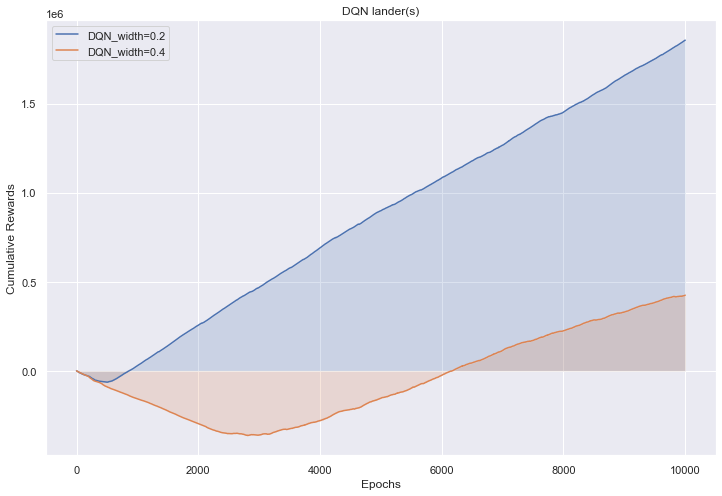

In [84]:
title=f"DQN lander(s)"
agents = ['DQN_width=0.2','DQN_width=0.4']
data=[dqn_total_rewards_2,dqn_total_rewards_4]
plot_cumulative_reward(agents,data,title)

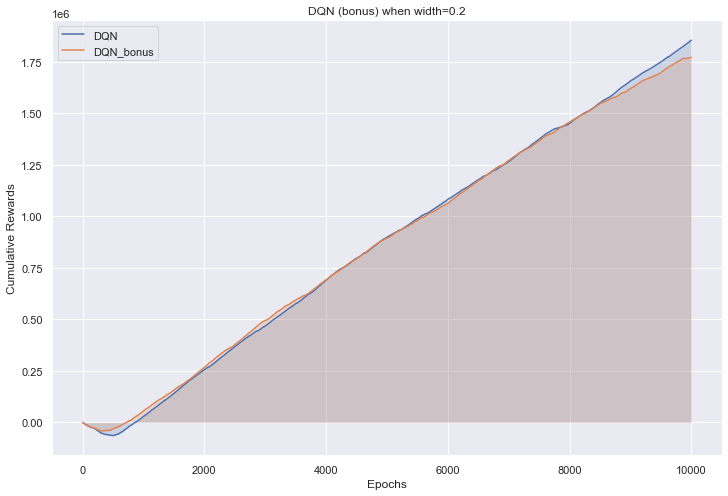

In [85]:
title=f"DQN (bonus) when width=0.2"
agents = ['DQN','DQN_bonus']
data=[dqn_total_rewards_2[:-1],dqn_bonus_total_rewards_2]
plot_cumulative_reward(agents,data,title)

In [148]:
n_episodes=10000

In [150]:
def plot_rewards(chosen_agents, agents_returns, num_episodes, window,widths, steady_coeff):
    mean=[]
    std=[]
    agents=[]
    
    num_intervals = int(num_episodes / window)
    plt.figure(figsize=(10,6))
    for agent, agent_total_returns,steady,width in zip(chosen_agents, agents_returns,steady_coeff,widths):
        print("{} lander average reward = {:.2f} when blind area width = {}".format(agent, \
                                             np.mean(agent_total_returns[steady:]), width))
        print("{} lander reward standard deviation = {:.2f} when blind area width = {}".format(agent, \
                                             np.std(agent_total_returns[steady:]) , width))
        l = []
        
        mean.append(np.mean(agent_total_returns[steady:]))
        std.append(np.std(agent_total_returns[steady:]))
        agents.append(agent)
        
        for j in range(num_intervals):
            l.append(round(np.mean(agent_total_returns[j * 100 : (j + 1) * 100]), 1))
        plt.plot(range(0, num_episodes, window), l)
    
    plt.xlabel("Episodes")
    plt.ylabel("Average reward per {} episodes".format(window))
    plt.title(f"RL Lander(s)")
    plt.legend(chosen_agents, loc="lower right")
    plt.show()
    
    return mean,std,agents

In [151]:
def plot_rewards_width(chosen_agents, agents_returns, num_episodes, window,width, steady_coeff):
    mean=[]
    std=[]
    agents=[]
    
    num_intervals = int(num_episodes / window)
    plt.figure(figsize=(10,6))
    for agent, agent_total_returns,steady in zip(chosen_agents, agents_returns,steady_coeff):
        print("{} lander average reward = {:.2f} when blind area width = {}".format(agent, \
                                             np.mean(agent_total_returns[steady:]), width))
        print("{} lander reward standard deviation = {:.2f} when blind area width = {}".format(agent, \
                                             np.std(agent_total_returns[steady:]) , width))
        l = []
        
        mean.append(np.mean(agent_total_returns[steady:]))
        std.append(np.std(agent_total_returns[steady:]))
        agents.append(agent)
        
        for j in range(num_intervals):
            l.append(round(np.mean(agent_total_returns[j * 100 : (j + 1) * 100]), 1))
            

        plt.plot(range(0, num_episodes, window), l)
    
    plt.xlabel("Episodes")
    plt.ylabel("Average reward per {} episodes".format(window))
    plt.title(f"RL Lander(s), width={width}")
    plt.legend(chosen_agents, loc="lower right")
    plt.show()
    
    return mean,std,agents

SARSA lander average reward = 59.23 when blind area width = 0.2
SARSA lander reward standard deviation = 151.85 when blind area width = 0.2
DQN lander average reward = 194.28 when blind area width = 0.2
DQN lander reward standard deviation = 131.97 when blind area width = 0.2


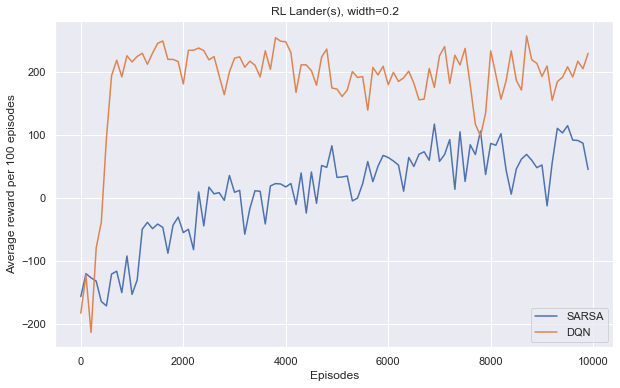

In [23]:
sns.set_theme(style="darkgrid")

chosen_agents = ['SARSA','DQN']
width=0.2
steady = [5000,4000]
agents_returns = [sarsa_total_rewards_2,dqn_total_rewards_2]

win = 100
_,_,_=plot_rewards_width(chosen_agents, agents_returns, n_episodes, win,width,steady)

SARSA lander average reward = 59.23 when blind area width = 0.2
SARSA lander reward standard deviation = 151.85 when blind area width = 0.2
DQN lander average reward = 194.28 when blind area width = 0.2
DQN lander reward standard deviation = 131.97 when blind area width = 0.2
DQN_bonus lander average reward = 180.05 when blind area width = 0.2
DQN_bonus lander reward standard deviation = 138.85 when blind area width = 0.2


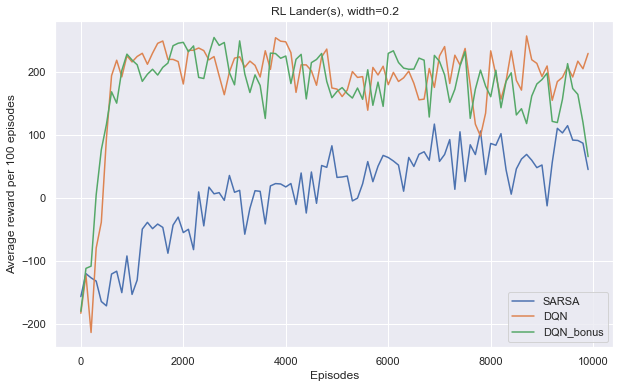

In [24]:
sns.set_theme(style="darkgrid")

chosen_agents = ['SARSA','DQN','DQN_bonus']
width=0.2
steady = [5000,4000,4000]
agents_returns = [sarsa_total_rewards_2,dqn_total_rewards_2,dqn_bonus_total_rewards_2]

win = 100
_,_,_=plot_rewards_width(chosen_agents, agents_returns, n_episodes, win,width,steady)

SARSA lander average reward = -24.87 when blind area width = 0.4
SARSA lander reward standard deviation = 128.32 when blind area width = 0.4
DQN lander average reward = 117.33 when blind area width = 0.4
DQN lander reward standard deviation = 162.40 when blind area width = 0.4
DQN_bonus lander average reward = 97.74 when blind area width = 0.4
DQN_bonus lander reward standard deviation = 164.86 when blind area width = 0.4
Q-learning lander average reward = -27.61 when blind area width = 0.4
Q-learning lander reward standard deviation = 129.21 when blind area width = 0.4


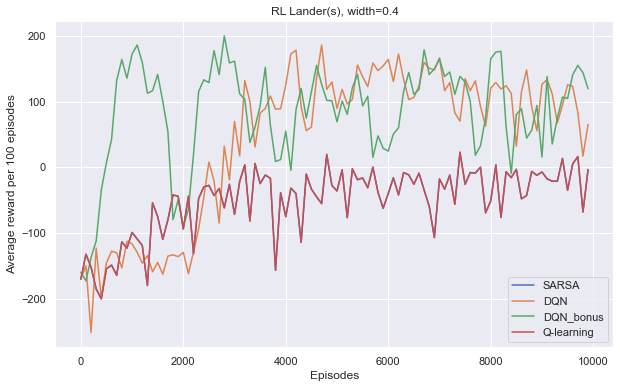

In [40]:
sns.set_theme(style="darkgrid")

chosen_agents = ['SARSA','DQN','DQN_bonus',"Q-learning"]
width=0.4
steady = [5000,4000,4000,4000]
agents_returns = [sarsa_total_rewards_4,dqn_total_rewards_4,dqn_bonus_total_rewards_4,qlearning_total_rewards_4]

win = 100
_,_,_=plot_rewards_width(chosen_agents, agents_returns, n_episodes, win,width,steady)

SARSA lander average reward = -24.87 when blind area width = 0.4
SARSA lander reward standard deviation = 128.32 when blind area width = 0.4
DQN lander average reward = 117.33 when blind area width = 0.4
DQN lander reward standard deviation = 162.40 when blind area width = 0.4


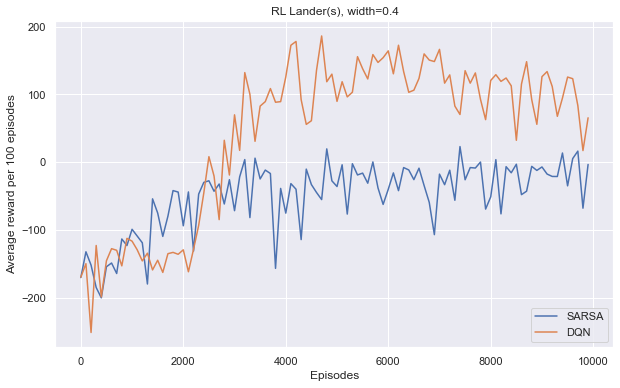

In [39]:
sns.set_theme(style="darkgrid")

chosen_agents = ['SARSA','DQN']
width=0.4
steady = [5000,4000]
agents_returns = [sarsa_total_rewards_4,dqn_total_rewards_4]

win = 100
_,_,_=plot_rewards_width(chosen_agents, agents_returns, n_episodes, win,width,steady)

DQN_width=0.2 lander average reward = 194.28 when blind area width = 0.2
DQN_width=0.2 lander reward standard deviation = 131.97 when blind area width = 0.2
DQN_width=0.4 lander average reward = 117.33 when blind area width = 0.4
DQN_width=0.4 lander reward standard deviation = 162.40 when blind area width = 0.4


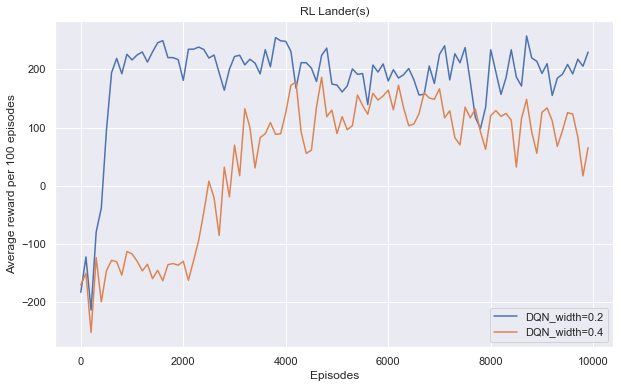

In [27]:
sns.set_theme(style="darkgrid")

chosen_agents = ['DQN_width=0.2','DQN_width=0.4']
width=[0.2,0.4]
steady_coeff = [4000,4000]
agents_returns = [dqn_total_rewards_2,dqn_total_rewards_4]

win = 100
_,_,_=plot_rewards(chosen_agents, agents_returns, n_episodes, win,width,steady_coeff)

DQN_width=0.2 lander average reward = 194.28 when blind area width = 0.2
DQN_width=0.2 lander reward standard deviation = 131.97 when blind area width = 0.2
DQN_width=0.4 lander average reward = 117.33 when blind area width = 0.4
DQN_width=0.4 lander reward standard deviation = 162.40 when blind area width = 0.4
SARSA_width=0.2 lander average reward = 59.23 when blind area width = 0.2
SARSA_width=0.2 lander reward standard deviation = 151.85 when blind area width = 0.2
SARSA_width=0.4 lander average reward = -24.87 when blind area width = 0.4
SARSA_width=0.4 lander reward standard deviation = 128.32 when blind area width = 0.4
DQN_width=0.2_Bonus lander average reward = 180.05 when blind area width = 0.2
DQN_width=0.2_Bonus lander reward standard deviation = 138.85 when blind area width = 0.2
DQN_width=0.4_Bonus lander average reward = 97.74 when blind area width = 0.4
DQN_width=0.4_Bonus lander reward standard deviation = 164.86 when blind area width = 0.4


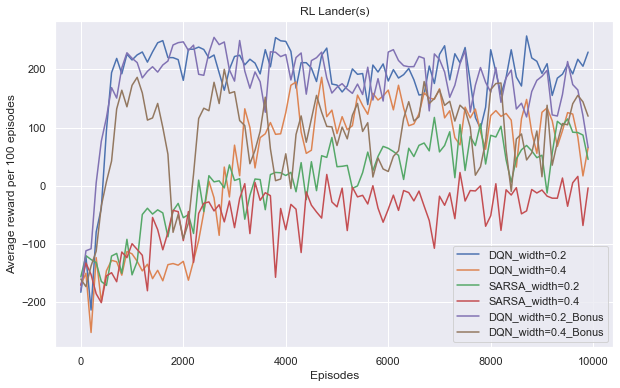

In [28]:
sns.set_theme(style="darkgrid")

chosen_agents = ['DQN_width=0.2','DQN_width=0.4','SARSA_width=0.2','SARSA_width=0.4','DQN_width=0.2_Bonus','DQN_width=0.4_Bonus']
width=[0.2,0.4,0.2,0.4,0.2,0.4]
steady_coeff = [4000,4000,5000,5000,4000,4000]
agents_returns = [dqn_total_rewards_2,dqn_total_rewards_4,sarsa_total_rewards_2,sarsa_total_rewards_4,\
                  dqn_bonus_total_rewards_2,dqn_bonus_total_rewards_4]

win = 100
mean,std,agents=plot_rewards(chosen_agents, agents_returns, n_episodes, win,width,steady_coeff)

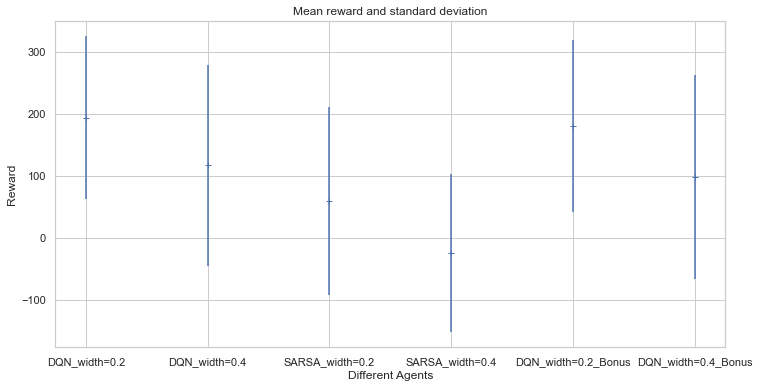

In [31]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
plt.errorbar(agents, mean, std, linestyle='None', marker='+')
plt.xlabel("Different Agents")
plt.ylabel("Reward")
plt.title("Mean reward and standard deviation")

plt.show()